In [1]:
import keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing import image
from keras.layers import Layer
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, concatenate
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers import BatchNormalization
from keras.callbacks import TensorBoard
from keras.models import Sequential, Model
from keras.layers import RepeatVector, Permute
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "DeepLearning/DeepLearningProject/Project/FullCNNversion/Train"
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = None
assert GOOGLE_DRIVE_PATH_AFTER_MYDRIVE is not None
GOOGLE_DRIVE_PATH = os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['27gIpN.jpg', '29Pkqp.jpg', '9KkoOf.jpg', '1PFDZe.jpg', '11Se02.jpg', '8X0jDX.jpg', '8oZO2i.jpg', '8ntGqA.jpg', '0qADtP.jpg', '30gdlQ.jpg']


In [5]:
# Get images
X = []
for filename in os.listdir(GOOGLE_DRIVE_PATH):
    X.append(img_to_array(load_img(os.path.join(GOOGLE_DRIVE_PATH, filename))))
X = np.array(X, dtype=float)
Xtrain = 1.0/255*X

In [6]:
#Load weights
inception = InceptionResNetV2(weights='imagenet', include_top=True)

225209952/225209952 [==============================] - 3s 0us/step


In [7]:
embed_input = Input(shape=(1000,))

#Encoder
encoder_input = Input(shape=(256, 256, 1,))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

#Fusion
fusion_output = RepeatVector(32 * 32)(embed_input)
fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
fusion_output = concatenate([encoder_output, fusion_output], axis=3)
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output)

#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

model = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

In [8]:
def create_inception_embedding(grayscaled_rgb):
    grayscaled_rgb_resized = []
    for i in grayscaled_rgb:
        i = resize(i, (299, 299, 3), mode='constant')
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    embed = inception.predict(grayscaled_rgb_resized)
    return embed

# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

#Generate training data
batch_size = 10

def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        grayscaled_rgb = gray2rgb(rgb2gray(batch))
        embed = create_inception_embedding(grayscaled_rgb)
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        X_batch = X_batch.reshape(X_batch.shape+(1,))
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield ([X_batch, create_inception_embedding(grayscaled_rgb)], Y_batch)


#Train model
model.compile(optimizer='rmsprop', loss='mse')
model.fit_generator(image_a_b_gen(batch_size), epochs=1, steps_per_epoch=1)

<ipython-input-8-5f195d029118>:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(image_a_b_gen(batch_size), epochs=1, steps_per_epoch=1)


1/1 [==============================] - 5s 5s/step


In [9]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "DeepLearning/DeepLearningProject/Project/FullCNNversion/Test"
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = None
assert GOOGLE_DRIVE_PATH_AFTER_MYDRIVE is not None
GOOGLE_DRIVE_PATH = os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['7Vizcm.jpg', '0yTHvf.jpg', '9KfZez.jpg', '4r3yxj.jpg', '3YFtxe.jpg', '6v14hm.jpg', '0fAtAB.jpg', '1QejlL 4.11.06 PM.jpg']


In [11]:
import os
import imageio
import numpy as np
from keras.preprocessing.image import img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb

# Assuming GOOGLE_DRIVE_PATH is defined earlier in your code

color_me = []
for filename in os.listdir(GOOGLE_DRIVE_PATH):
    color_me.append(img_to_array(load_img(os.path.join(GOOGLE_DRIVE_PATH, filename))))
color_me = np.array(color_me, dtype=float)
gray_me = gray2rgb(rgb2gray(1.0/255*color_me))
color_me_embed = create_inception_embedding(gray_me)
color_me = rgb2lab(1.0/255*color_me)[:, :, :, 0]
color_me = color_me.reshape(color_me.shape + (1,))

# Test model
output = model.predict([color_me,color_me_embed])
output = output * 128
print("Output shape:", output.shape)
print("Output data type:", output.dtype)

# Create the 'result' directory if it doesn't exist
result_dir = 'DeepLearning/DeepLearningProject/Project/FullCNNversion/result'
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

# Output colorizations
# Output colorizations
for i in range(len(output)):
    # Create LAB image with original L channel and colorized A and B channels
    lab_output = np.zeros((256, 256, 3))
    lab_output[:, :, 0] = color_me[i][:, :, 0]  # Original L channel
    lab_output[:, :, 1:] = output[i]  # Colorized A and B channels

   # Clip LAB output to valid range
    lab_output[:, :, 1:] = np.clip(lab_output[:, :, 1:], -128, 127)

   # Normalize LAB image to the range [0, 100]
    lab_output[:, :, 1:] = (lab_output[:, :, 1:] + 128) * 100.0 / 255.0

   # Convert LAB image to RGB
    rgb_output = lab2rgb(lab_output)

   # Clip RGB output to valid range
    rgb_output = np.clip(rgb_output, 0, 1)


    # Save the image
    imageio.imwrite(os.path.join(result_dir, "img_" + str(i) + ".png"), (rgb_output * 255).astype(np.uint8))

1/1 [==============================] - 4s 4s/step
Output shape: (8, 256, 256, 2)
Output data type: float32


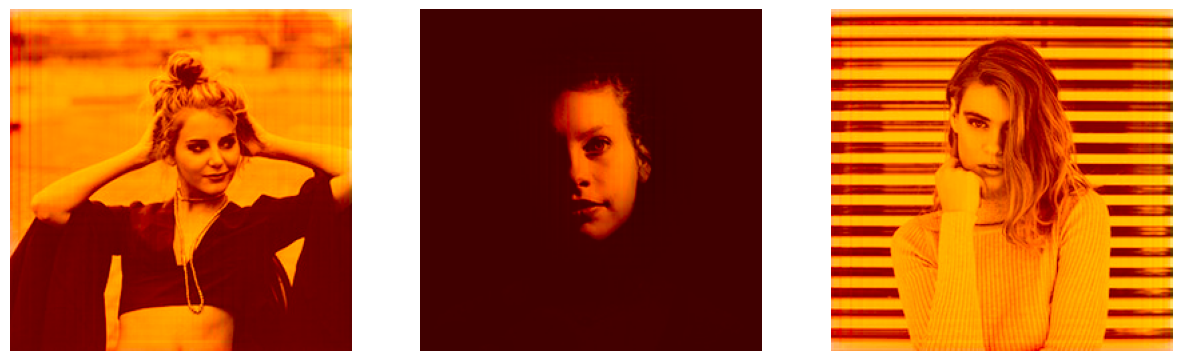

In [32]:
from sklearn.metrics import mean_squared_error
import math

# Load the ground truth images from the test set
ground_truth_images = []
for filename in os.listdir(GOOGLE_DRIVE_PATH):
    ground_truth_images.append(img_to_array(load_img(os.path.join(GOOGLE_DRIVE_PATH, filename))))
ground_truth_images = np.array(ground_truth_images, dtype=float)

# Convert ground truth images to LAB color space and discard L channel
ground_truth_images_lab = rgb2lab(ground_truth_images)[:, :, :, 1:]

# Reshape ground_truth_images_lab array
ground_truth_images_reshaped = ground_truth_images_lab.reshape((-1, 256, 256, 2))

# Print shapes for debugging
print("Shape of ground_truth_images_reshaped:", ground_truth_images_reshaped.shape)
print("Shape of output_reshaped:", output_reshaped.shape)

# Flatten the arrays
ground_truth_images_flat = ground_truth_images_reshaped.reshape((-1, 256 * 256 * 2))
output_flat = output_reshaped.reshape((-1, 256 * 256 * 2))

# Calculate MSE
mse = mean_squared_error(ground_truth_images_flat, output_flat)
print("Mean Squared Error (MSE):", mse)

# Calculate average MSE
average_mse = np.mean(mse)
print("Average Mean Squared Error (MSE):", average_mse)

# Calculate PSNR
psnr_values = []
for i in range(len(output_reshaped)):
    ground_truth_image = ground_truth_images_reshaped[i][:, :, 0]  # Select the A channel
    output_image = output_reshaped[i][:, :, 0]  # Select the A channel
    psnr_val = psnr(ground_truth_image, output_image)
    psnr_values.append(psnr_val)

average_psnr = np.mean(psnr_values)
print("Average PSNR:", average_psnr)


Shape of ground_truth_images_reshaped: (8, 256, 256, 2)
Shape of output_reshaped: (8, 256, 256, 2)
Mean Squared Error (MSE): 6122.372923058547
Average Mean Squared Error (MSE): 6122.372923058547
Average PSNR: 23.052795542631287
